# Gaussian Mixture Model Example

In [2]:
# Imports
import jax
import jax.numpy as jnp
import jax.random as random
import numpy as np
import numpyro.distributions as dist
import ot
from jax import grad, vmap
from jax.tree_util import Partial
from jaxtyping import Array, PRNGKeyArray, Real

from diffusionlib.conditioning_method import ConditioningMethodName, get_conditioning_method
from diffusionlib.config_definition.task import TaskConfig
from diffusionlib.sampler import DDIMVP, PCSampler
from diffusionlib.sde import SDE, VP
from diffusionlib.solver import EulerMaruyama
from diffusionlib.util.plot import plot_image, plot_single_image

From the [MCGDiff paper](https://arxiv.org/pdf/2308.07983.pdf) (page 5), the marginals of the
forward process are available in closed form, meaning we don't need a trained model to
estimate the score or noise ($\epsilon$).

In [3]:
# Define score and epsilon functions
def get_score_fn(ou_dist, sde: SDE):
    return vmap(grad(lambda x, t: ou_dist(sde.marginal_mean_coeff(t)).log_prob(x)))


# NOTE: model/epsilon function is just the negative score by the variance
def get_model_fn(ou_dist, sde: SDE):
    return vmap(
        grad(
            lambda x, t: -jnp.sqrt(sde.marginal_variance(t))
            * ou_dist(sde.marginal_mean_coeff(t)).log_prob(x)
        )
    )

In [4]:
# Define posterior
def gaussian_posterior(
    y: Real[Array, " num_observations"],
    likelihood_a: Real[Array, "num_observations dimension"],
    likelihood_bias: Real[Array, " num_observations"],
    likelihood_precision: Real[Array, "num_observations num_observations"],
    prior_loc: Real[Array, " dimension"],
    prior_covar: Real[Array, "dimension dimension"],
) -> dist.MultivariateNormal:
    # Compute the precision matrix of the prior distribution
    prior_precision_matrix = jnp.linalg.inv(prior_covar)

    # Calculate the precision matrix of the posterior distribution
    posterior_precision_matrix = (
        prior_precision_matrix + likelihood_a.T @ likelihood_precision @ likelihood_a
    )

    # Calculate the covariance matrix of the posterior distribution
    posterior_covariance_matrix = jnp.linalg.inv(posterior_precision_matrix)

    # Calculate the mean of the posterior distribution
    posterior_mean = posterior_covariance_matrix @ (
        likelihood_a.T @ likelihood_precision @ (y - likelihood_bias)
        + prior_precision_matrix @ prior_loc
    )

    # Ensure symmetry and numerical stability of the covariance matrix
    # Handle potential numerical issues by regularization
    try:
        posterior_covariance_matrix = (
            posterior_covariance_matrix + posterior_covariance_matrix.T
        ) / 2
    except ValueError:
        u, s, v = jnp.linalg.svd(posterior_covariance_matrix, full_matrices=False)
        s = jnp.clip(s, 1e-12, 1e6).real
        posterior_covariance_matrix = u.real @ jnp.diag(s) @ v.real
        posterior_covariance_matrix = (
            posterior_covariance_matrix + posterior_covariance_matrix.T
        ) / 2

    return dist.MultivariateNormal(
        loc=posterior_mean, covariance_matrix=posterior_covariance_matrix
    )

In [5]:
# Define mixture model function
def ou_mixt(mean_coeff: float, means: Array, dim: int, weights: Array) -> dist.MixtureSameFamily:
    means = jnp.vstack(means) * mean_coeff
    covs = jnp.repeat(jnp.eye(dim)[None], axis=0, repeats=means.shape[0])
    return dist.MixtureSameFamily(
        component_distribution=dist.MultivariateNormal(loc=means, covariance_matrix=covs),
        mixing_distribution=dist.CategoricalProbs(weights),
    )

In [6]:
# Define posterior for the mixture model
def get_posterior(
    obs: Array, prior: dist.MixtureSameFamily, a: Array, sigma_y: Array
) -> dist.MixtureSameFamily:
    mixing_dist: dist.CategoricalProbs = prior.mixing_distribution
    component_dist: dist.MultivariateNormal = prior.component_distribution  # type: ignore
    comp_mean = component_dist.mean
    comp_cov: Array = component_dist.covariance_matrix  # type: ignore

    # Precompute the inverse of the observation noise covariance matrix
    precision = jnp.linalg.inv(sigma_y)
    modified_means = []
    modified_covars = []
    weights = []

    # Iterate through the components of the prior distribution
    for loc, cov, weight in zip(comp_mean, comp_cov, mixing_dist.probs):
        # Compute the posterior distribution for the current component
        new_dist = gaussian_posterior(obs, a, jnp.zeros_like(obs), precision, loc, cov)
        modified_means.append(new_dist.mean)
        modified_covars.append(new_dist.covariance_matrix)

        # Calculate the prior likelihood and residual
        prior_x = dist.MultivariateNormal(loc, covariance_matrix=cov)
        residue = obs - a @ new_dist.loc

        # Compute log-probability contributions
        log_constant = (
            -0.5 * residue @ precision @ residue.T
            + prior_x.log_prob(new_dist.mean)
            - new_dist.log_prob(new_dist.mean)
        )

        # Compute the log weight for the component
        weights.append(jnp.log(weight) + log_constant)

    # Normalize weights
    weights = jnp.array(weights)
    normalized_weights = weights - jax.scipy.special.logsumexp(weights)

    # Construct categorical distribution from the normalized weights
    categorical_distribution = dist.CategoricalLogits(logits=normalized_weights)

    # Construct a mixture distribution of multivariate normals
    multivariate_mixture = dist.MultivariateNormal(
        loc=jnp.stack(modified_means, axis=0),
        covariance_matrix=jnp.stack(modified_covars, axis=0),
    )

    return dist.MixtureSameFamily(categorical_distribution, multivariate_mixture)

In [7]:
def extended_svd(a: Array) -> tuple[Array, Array, Array, Array]:
    # Compute the singular value decomposition
    u, s, v = jnp.linalg.svd(a, full_matrices=False)

    # Create a coordinate mask based on the length of the singular values
    coordinate_mask = jnp.concatenate([jnp.ones(len(s)), jnp.zeros(v.shape[0] - len(s))]).astype(
        bool
    )

    return u, s, v, coordinate_mask

In [8]:
def generate_measurement_equations(
    dim: int,
    num_observations: int,
    mixt: dist.MixtureSameFamily,
    noise_std: float,
    key: PRNGKeyArray,
):
    # Generate random keys for different sources of randomness
    key_a, key_diag, key_init_sample, key_init_obs = random.split(key, 4)

    # Create random matrix
    a = random.normal(key_a, (num_observations, dim))

    # Build extended SVD
    u, s, v, coordinate_mask = extended_svd(a)

    # Re-create `s` using uniform sampling, sorting the generated values to align with
    # properties of singular values being ordered in the SVD Sigma (`s`) matrix
    s_new = jnp.sort(random.uniform(key_diag, s.shape), descending=True)
    s_new_mat = jnp.diag(s_new)

    # Re-construct `a` using the sorted diag and coordinate mask
    a_recon = u @ s_new_mat @ v[coordinate_mask]

    # Sample initial data and simulate initial observations
    init_sample = mixt.sample(key_init_sample)
    init_obs = a_recon @ init_sample
    init_obs += random.normal(key_init_obs, init_obs.shape) * noise_std

    # Construct observation noise covariance matrix
    sigma_y = jnp.diag(jnp.full(num_observations, noise_std**2))

    return a_recon, sigma_y, u, s_new, v, coordinate_mask, init_obs

In [9]:
# Setup
config = TaskConfig.load()
jax.default_device = jax.devices()[0]
key = random.PRNGKey(config.seed)
color_posterior = "#a2c4c9"
color_algorithm = "#ff7878"

In [10]:
dim = 2
num_samples = 1000
num_observations = 20
measurement_noise_std = 1.0
size = 8.0  # mean multiplier

# Setup SDE
sde = VP(jnp.array(config.model.beta_min), jnp.array(config.model.beta_max))

# Setup inverse problem
means = [jnp.array([-size * i, -size * j] * (dim // 2)) for i in range(-2, 3) for j in range(-2, 3)]
weights = jnp.ones(len(means))
weights = weights / weights.sum()

ou_mixt_fun = Partial(ou_mixt, means=means, dim=dim, weights=weights)
mixt = ou_mixt_fun(1)

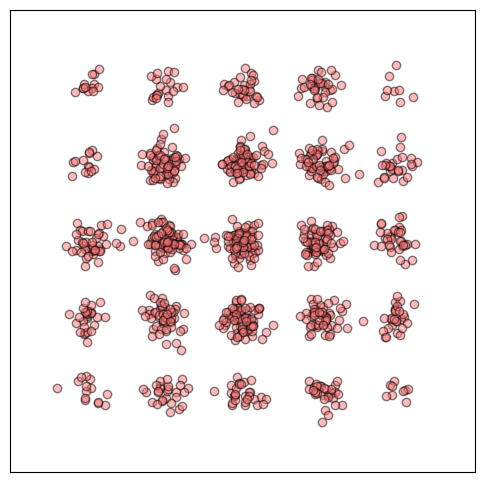

In [11]:
# Get prior samples
score = get_score_fn(ou_mixt_fun, sde)
model = get_model_fn(ou_mixt_fun, sde)

sampler = DDIMVP(shape=(num_samples, dim), model=model, beta_min=0.01, beta_max=20.0, eta=0.9)

key, sub_key = random.split(key)
samples = sampler.sample(sub_key)

# Plot prior samples
plot_single_image([0, 1], samples, color=color_algorithm)

In [12]:
key, sub_key = random.split(key)

(a, sigma_y, u, diag, v, coordinate_mask, init_obs) = generate_measurement_equations(
    dim, num_observations, mixt, measurement_noise_std, sub_key
)
posterior = get_posterior(init_obs, mixt, a, sigma_y)

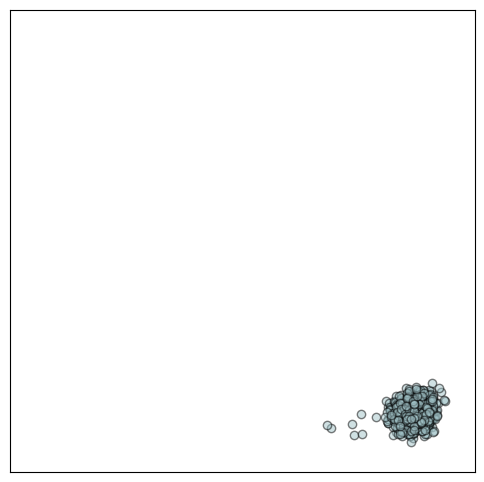

In [13]:
# Get posterior samples (using NUTS)
key, sub_key = random.split(key)

posterior_samples = posterior.sample(sub_key, (num_samples,))
plot_single_image(
    [0, 1],
    posterior_samples,
    color=color_posterior,
)

In [14]:
y: Real[Array, "{num_samples} {num_observations}"] = jnp.tile(init_obs, (num_samples, 1))
h: Real[Array, "{num_observations} {dim}"] = jnp.array(a, dtype=jnp.float32)

In [15]:
conditioning_method = get_conditioning_method(
    name=ConditioningMethodName.JAC_FWD_GUIDANCE,
    sde=sde.reverse(score),
    y=y,
    H=h,
    observation_map=lambda x: h @ x.flatten(),
    shape=(num_samples, dim),
    scale=config.solver.num_outer_steps + (config.solver.dps_scale_hyperparameter or 0),
    **config.sampling.model_dump(),
)

solver = EulerMaruyama(
    num_steps=1000, sde=sde.reverse(model).guide(conditioning_method.guidance_score_func)
)
sampler = PCSampler(shape=(num_samples, dim), outer_solver=solver)

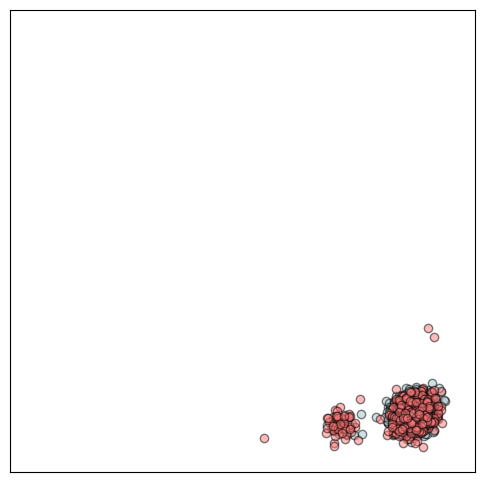

In [16]:
key, sub_key = random.split(key)
samples = sampler.sample(sub_key)
samples = samples.reshape(num_samples, dim)

plot_image([0, 1], samples, posterior_samples)

In [17]:
ot_sliced_wasserstein_distance = ot.sliced_wasserstein_distance(
    np.array(posterior_samples),
    np.array(samples),
    n_projections=10_000,
)
print(ot_sliced_wasserstein_distance)

0.8104342074617209
